# Verification of the PDE solver for convection and diffusion

I will use numerical Dirac-delta initial conditions for the density and examine two separate cases: one with only convection, the other with only diffusion.

The numerical Dirac delta function gives:
$$ n_{\delta}(r,\varepsilon)=\frac{(1+\cos(\frac{\pi r}{\varepsilon}))}{2\cdot\varepsilon} $$
between:
$$ r<\varepsilon\quad\text{and}\quad r>-\varepsilon$$

The general form of the PDE which we want to solve is the following:
$$\frac{\partial n(r,t)}{\partial t}=D\frac{\partial^2 n(r,t)}{\partial r^2}-K\frac{\partial n(r,t)}{\partial r} $$

In [1]:
import fipy as fp  ## finite volume PDE solver
from fipy.tools import numerix  ## requirement for FiPy, in practice same as numpy
import copy  ## we need the deepcopy() function because some FiPy objects are mutable
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.interpolate
import scipy.special as sc

plt.rcParams.update({'font.size': 18})

## numeric implementation of Dirac delta function as mentioned in the equation above
def delta_func(x, epsilon, coeff):
    return ((x < epsilon) & (x > -epsilon)) * \
        (coeff * (1 + numerix.cos(numerix.pi * x / epsilon)) / (2 * epsilon))


## Only convection

When there is only convection in the examined space, the simplified equation:
$$\frac{\partial n(r,t)}{\partial t}=-K\frac{\partial n(r,t)}{\partial r}$$

Suppose
$$n(r,0)=g(r)$$

Then the analytical solution:
$$n(r,t)=g(-K\cdot t+r)$$

In this case $g()$ is the numerical Dirac delta function as mentioned above.

### The K=100, D=0 case can be seen in the next example

<ipython-input-3-461c6ebbb770>:68: UserWarning: Log scale: values of z <= 0 have been masked
  plot = plt.contourf(solution[0,:,0], np.linspace(dt,duration,nt), solution[:,:,1],
<ipython-input-3-461c6ebbb770>:116: UserWarning: Log scale: values of z <= 0 have been masked
  plot = plt.contourf(analytical[0,:,0], np.linspace(dt,duration,nt), analytical[:,:,1],


Text(0.5, 1.0, 'Analytical solution')

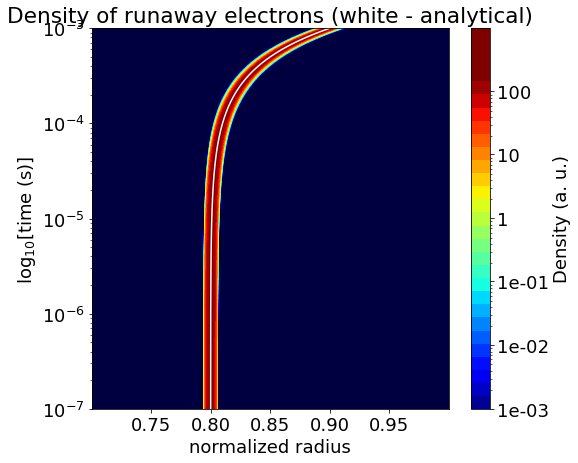

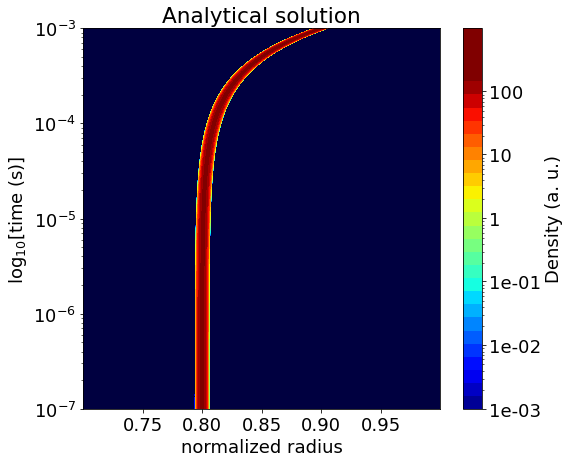

In [3]:
## K=100, D is very small
R_from = 0.7  ## inner radius in meters
R_to = 1.  ## outer radius in meters
nr = 10000  ## number of mesh cells
dr = (R_to - R_from) / nr  ## distance between the centers of the mesh cells
duration = 0.001  ## length of examined time evolution in seconds
nt = 10000  ## number of timesteps
dt = duration / nt  ## length of one timestep

## 3D array for storing the density with the correspondant radius values
## the density values corresponding to the n-th timestep will be in the n-th line 
solution = np.zeros((nt,nr,2))
## loading the radial coordinates into the array
for j in range(nr):
    solution[:,j,0] = (j * dr) + (dr / 2) + R_from

mesh = fp.Grid1D(dx=dr, nx=nr)  ## 1D mesh based on the radial coordinates 
mesh = mesh + (0.7,)  ## translating the mesh to r=0.7
n = fp.CellVariable(mesh=mesh)  ## fipy.CellVariable for the density solution in each timestep

diracLoc = 0.8  ## location of the middle of the Dirac delta
diracCoeff = 1.  ## Dirac delta coefficient ("height")
diracPercentage = 2  ## width of Dirac delta (full width from 0 to 0) in percentage of full examined radius
diracWidth = int((nr / 100) * diracPercentage)

## diffusion coefficient
diffCoeff = fp.CellVariable(mesh=mesh, value=1e-18)
## convection coefficient - must be a vector
# cC = (numerix.sin(mesh.x)) * 2
convCoeff = fp.CellVariable(mesh=mesh, value=(100.,))

## boundary conditions
gradLeft = (0.,)  ## density gradient (at the "left side of the radius") - must be a vector
valueRight = 0.  ## density value (at the "right end of the radius")
n.faceGrad.constrain(gradLeft, where=mesh.facesLeft)  ## applying Neumann boundary condition
n.constrain(valueRight, mesh.facesRight)  ## applying Dirichlet boundary condition
convCoeff.setValue(0, where=mesh.x<(R_from + dr))  ## convection coefficient 0 at the inner edge

## applying initial conditions
n.setValue(delta_func(mesh.x - diracLoc, diracWidth * dr, diracCoeff))
## the PDE
eq = (fp.TransientTerm() == fp.DiffusionTerm(coeff=diffCoeff)
      - fp.ConvectionTerm(coeff=convCoeff))

## Solving the PDE and storing the data
for i in range(nt):
    eq.solve(var=n, dt=dt)
    solution[i,0:nr,1]=copy.deepcopy(n.value)

## Plotting the numerical solution
ticks = 6
levels = 30
logdiff = 6
figsize = (8,7)
sol_min = solution[:,:,1].min()
sol_max = solution[:,:,1].max()
logmax = math.ceil(np.log10(sol_max))
logmin = logmax - logdiff
numofticks = ticks
div = logdiff // numofticks
power = np.arange((logmax - (numofticks * div)), logmax, div)
array1 = np.zeros(len(power)) + 10.
ticks1 = np.power(array1, power)
levels1 = np.logspace(logmin,logmax,levels, base=10.0)
norm = matplotlib.colors.LogNorm(vmin=(10 ** logmin),vmax=sol_max)
formatter = matplotlib.ticker.LogFormatter(10, labelOnlyBase=False)
fig = plt.figure(figsize=figsize)
plot = plt.contourf(solution[0,:,0], np.linspace(dt,duration,nt), solution[:,:,1],
                        levels=levels1, norm=norm, cmap=plt.cm.jet)
axes = plt.gca()
axes.set_facecolor((0.,0.,0.25)) ## dark blue will display where the values are too small
axes.set_yscale('log')
cbar = plt.colorbar(ticks=ticks1, format=formatter)
cbar.set_label(r'Density (a. u.)')
plt.xlabel('normalized radius')
plt.ylabel(r'log$_{10}$[time (s)]')
plt.title(r'Density of runaway electrons (white - analytical)')

## new np.array for the analytical solution
analytical = np.zeros((nt,nr,2))
## 2D np.array for the r-t coordinates of the maximums of the analytical solution
## needed for the white line on top of the numerical solution
A_2D = np.zeros((nt,2))  
## loading the radial coordinates into the array
for j in range(nr):
    analytical[:,j,0] = (j * dr) + (dr / 2) + R_from

## the first line inside the for loop contains the analytical solution based on the equation above
## g()=delta_func(), K=100, t=i*dt, r=r-diracLoc 
for i in range(nt):
    analytical[i,0:nr,1] = delta_func(- 100 * i * dt + (analytical[i,0:nr,0] - diracLoc), diracWidth * dr, diracCoeff)
    ## filling with time coordinates
    A_2D[i,0] = i * dt  
    ## filling with the maximums' radial coordinates
    A_2D[i,1] = R_from + (dr / 2) + dr * np.argmax(analytical[i,0:nr,1])
    
## drawing the maximum-line of the analytical solution on top of the numerical
plt.plot(A_2D[:,1],A_2D[:,0], color='white')
## optional high-res figure export
#plt.savefig('conv_N.jpg',dpi=300)

## Plotting the analytical solution
sol_min = analytical[:,:,1].min()
sol_max = analytical[:,:,1].max()
logmax = math.ceil(np.log10(sol_max))
logmin = logmax - logdiff
numofticks = ticks
div = logdiff // numofticks
power = np.arange((logmax - (numofticks * div)), logmax, div)
array1 = np.zeros(len(power)) + 10.
ticks1 = np.power(array1, power)
levels1 = np.logspace(logmin,logmax,levels, base=10.0)
norm = matplotlib.colors.LogNorm(vmin=(10 ** logmin),vmax=sol_max)
formatter = matplotlib.ticker.LogFormatter(10, labelOnlyBase=False)
fig = plt.figure(figsize=figsize)
plot = plt.contourf(analytical[0,:,0], np.linspace(dt,duration,nt), analytical[:,:,1],
                        levels=levels1, norm=norm, cmap=plt.cm.jet)
axes = plt.gca()
axes.set_facecolor((0.,0.,0.25)) ## dark blue will display where the values are too small
axes.set_yscale('log')
cbar = plt.colorbar(ticks=ticks1, format=formatter)
cbar.set_label(r'Density (a. u.)')
plt.xlabel('normalized radius')
plt.ylabel(r'log$_{10}$[time (s)]')
plt.title(r'Analytical solution')
#plt.savefig('conv_A.jpg', dpi=300)

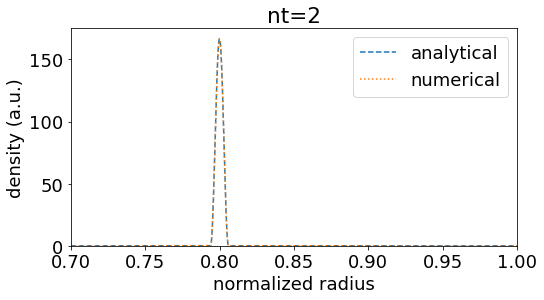

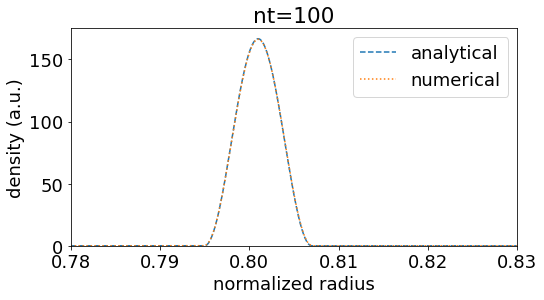

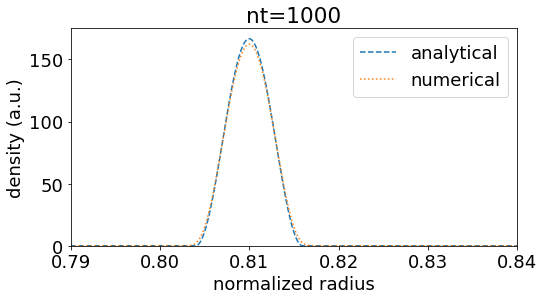

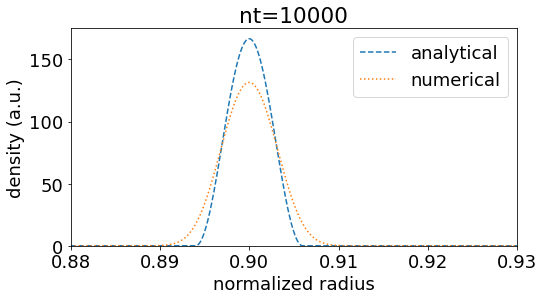

In [7]:
fig2 = plt.figure(figsize=(8,4))
plt.plot(analytical[1,0:nr,0], analytical[1,0:nr,1], label="analytical", linestyle="--")
plt.plot(solution[1,0:nr,0], solution[1,0:nr,1], label="numerical", linestyle=":")
axes = plt.gca()
axes.set_ylim(0.,)
axes.set_xlim(0.7,1.)
plt.xlabel('normalized radius')
plt.ylabel('density (a.u.)')
plt.title("nt=2")
plt.legend()
plt.savefig('conv_step2.jpg', dpi=150)

fig100 = plt.figure(figsize=(8,4))
plt.plot(analytical[99,0:nr,0], analytical[99,0:nr,1], label="analytical", linestyle="--")
plt.plot(solution[99,0:nr,0], solution[99,0:nr,1], label="numerical", linestyle=":")
axes = plt.gca()
axes.set_ylim(0.,)
axes.set_xlim(0.78,0.83)
plt.xlabel('normalized radius')
plt.ylabel('density (a.u.)')
plt.title("nt=100")
plt.legend()
plt.savefig('conv_step100.jpg', dpi=150)

fig1000 = plt.figure(figsize=(8,4))
plt.plot(analytical[999,0:nr,0], analytical[999,0:nr,1], label="analytical", linestyle="--")
plt.plot(solution[999,0:nr,0], solution[999,0:nr,1], label="numerical", linestyle=":")
axes = plt.gca()
axes.set_ylim(0.,)
axes.set_xlim(0.79,0.84)
plt.xlabel('normalized radius')
plt.ylabel('density (a.u.)')
plt.title("nt=1000")
plt.legend()
plt.savefig('conv_step1000.jpg', dpi=150)

fig10000 = plt.figure(figsize=(8,4))
plt.plot(analytical[9999,0:nr,0], analytical[9999,0:nr,1], label="analytical", linestyle="--")
plt.plot(solution[9999,0:nr,0], solution[9999,0:nr,1], label="numerical", linestyle=":")
axes = plt.gca()
axes.set_ylim(0.,)
axes.set_xlim(0.88,0.93)
plt.xlabel('normalized radius')
plt.ylabel('density (a.u.)')
plt.title("nt=10000")
plt.legend()
plt.savefig('conv_step10000.jpg', dpi=150)

## Only diffusion
The form of the PDE:
$$\frac{\partial n(r,t)}{\partial t}=D\frac{1}{J}\frac{\partial^2 Jn(r,t)}{\partial r^2}$$


<ipython-input-2-e367532bb2e5>:65: UserWarning: The following kwargs were not used by contour: 'datamin'
  plot = plt.contourf(solution[0,:,0], np.linspace(dt,duration,nt), solution[:,:,1],


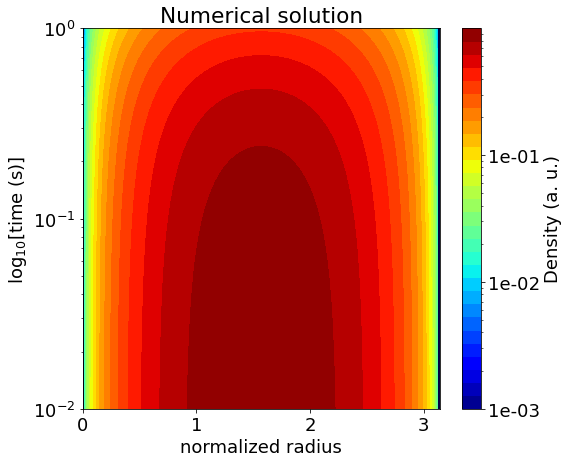

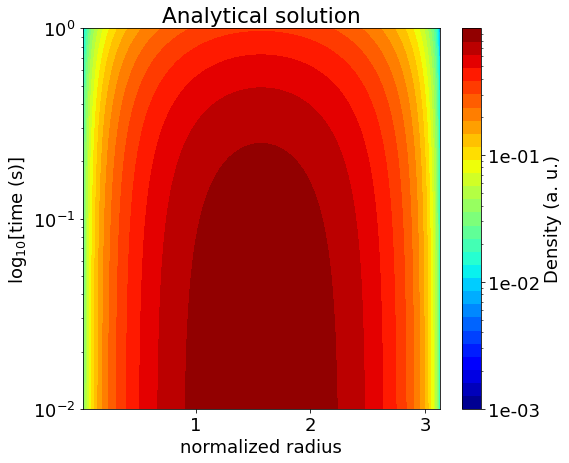

In [2]:
## sin(x) initial condition, Dirichlet boundary conditions on both edges

R_from = 0.  ## inner radius in meters
R_to = math.pi  ## outer radius in meters
nr = 100  ## number of mesh cells
dr = (R_to - R_from) / nr  ## distance between the centers of the mesh cells
duration = 1.  ## length of examined time evolution in seconds
nt = 100  ## number of timesteps
dt = duration / nt  ## length of one timestep

## 3D array for storing the density with the correspondant radius values
## the density values corresponding to the n-th timestep will be in the n-th line 
solution = np.zeros((nt,nr,2))
## loading the radial coordinates into the array
for j in range(nr):
    solution[:,j,0] = (j * dr) + (dr / 2) + R_from

mesh = fp.Grid1D(dx=dr, nx=nr)  ## 1D mesh based on the radial coordinates 
mesh = mesh + (R_from,)  ## translating the mesh to R_from
n = fp.CellVariable(mesh=mesh)  ## fipy.CellVariable for the density solution in each timestep

## diffusion coefficient
diffCoeff = fp.CellVariable(mesh=mesh, value=1.)
## convection coefficient - must be a vector
# cC = (numerix.sin(mesh.x)) * 2
convCoeff = fp.CellVariable(mesh=mesh, value=(0.,))

## boundary conditions
gradLeft = (0.,)  ## density gradient (at the "left side of the radius") - must be a vector
valueRight = 0.  ## density value (at the "right end of the radius")
valueLeft = 0.
#n.faceGrad.constrain(gradLeft, where=mesh.facesLeft)  ## applying Neumann boundary condition
n.constrain(valueRight, mesh.facesRight)  ## applying Dirichlet boundary condition
n.constrain(valueLeft, mesh.facesLeft)
#convCoeff.setValue(0, where=mesh.x<(R_from + dr))  ## convection coefficient 0 at the inner edge

## applying initial conditions
n.setValue(numerix.sin(mesh.x))
## the PDE
eq = (fp.TransientTerm() == fp.DiffusionTerm(coeff=diffCoeff)
      - fp.ConvectionTerm(coeff=convCoeff))

## Solving the PDE and storing the data
for i in range(nt):
    eq.solve(var=n, dt=dt)
    solution[i,0:nr,1]=copy.deepcopy(n.value)

ticks = 3
levels = 30
logdiff = 3
figsize = (8,7)
sol_min = solution[:,:,1].min()
sol_max = solution[:,:,1].max()
logmax = math.ceil(np.log10(sol_max))
logmin = logmax - logdiff
numofticks = ticks
div = logdiff // numofticks
power = np.arange((logmax - (numofticks * div)), logmax, div)
array1 = np.zeros(len(power)) + 10.
ticks1 = np.power(array1, power)
levels1 = np.logspace(logmin,logmax,levels, base=10.0)
norm = matplotlib.colors.LogNorm(vmin=(10 ** logmin),vmax=sol_max)
formatter = matplotlib.ticker.LogFormatter(10, labelOnlyBase=False)
fig = plt.figure(figsize=figsize)
plot = plt.contourf(solution[0,:,0], np.linspace(dt,duration,nt), solution[:,:,1],
                        levels=levels1, norm=norm, cmap=plt.cm.jet, datamin=0.)
axes = plt.gca()
axes.set_facecolor((0.,0.,0.25)) ## dark blue will display where the values are too small
axes.set_yscale('log')
axes.set_xlim(0.,math.pi)
cbar = plt.colorbar(ticks=ticks1, format=formatter)
cbar.set_label(r'Density (a. u.)')
plt.xlabel('normalized radius')
plt.ylabel(r'log$_{10}$[time (s)]')
plt.title(r'Numerical solution')

## new np.array for the analytical solution
analytical = np.zeros((nt,nr,2))
## loading the radial coordinates into the array
for j in range(nr):
    analytical[:,j,0] = (j * dr) + (dr / 2) + R_from

## the first line inside the for loop contains the analytical solution based on the equation above
## g()=delta_func(), K=100, t=i*dt, r=r-diracLoc 
for i in range(nt):
    analytical[i,0:nr,1] = np.sin(analytical[i,0:nr,0]) * math.exp(-i * dt)

    
## drawing the maximum-line of the analytical solution on top of the numerical
#plt.plot(A_2D[:,1],A_2D[:,0], color='white')
## optional high-res figure export
plt.savefig('diff_sin_100x100_N.jpg',dpi=150)

## Plotting the analytical solution
sol_min = analytical[:,:,1].min()
sol_max = analytical[:,:,1].max()
logmax = math.ceil(np.log10(sol_max))
logmin = logmax - logdiff
numofticks = ticks
div = logdiff // numofticks
power = np.arange((logmax - (numofticks * div)), logmax, div)
array1 = np.zeros(len(power)) + 10.
ticks1 = np.power(array1, power)
levels1 = np.logspace(logmin,logmax,levels, base=10.0)
norm = matplotlib.colors.LogNorm(vmin=(10 ** logmin),vmax=sol_max)
formatter = matplotlib.ticker.LogFormatter(10, labelOnlyBase=False)
fig = plt.figure(figsize=figsize)
plot = plt.contourf(analytical[0,:,0], np.linspace(dt,duration,nt), analytical[:,:,1],
                        levels=levels1, norm=norm, cmap=plt.cm.jet)
axes = plt.gca()
axes.set_facecolor((0.,0.,0.25)) ## dark blue will display where the values are too small
axes.set_yscale('log')
cbar = plt.colorbar(ticks=ticks1, format=formatter)
cbar.set_label(r'Density (a. u.)')
plt.xlabel('normalized radius')
plt.ylabel(r'log$_{10}$[time (s)]')
plt.title(r'Analytical solution')
plt.savefig('diff_sin_100x100_A.jpg', dpi=150)

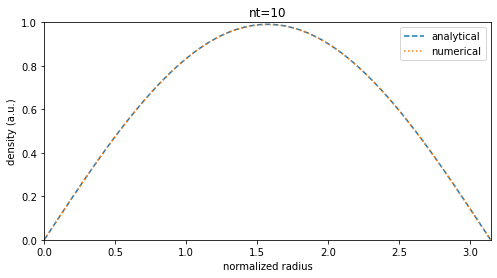

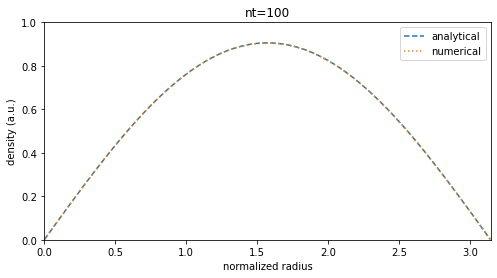

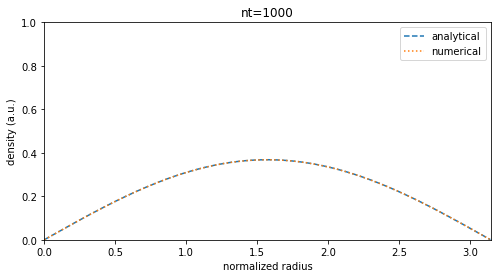

In [37]:
fig10 = plt.figure(figsize=(8,4))
plt.plot(analytical[9,0:nr,0], analytical[9,0:nr,1], label="analytical", linestyle="--")
plt.plot(solution[9,0:nr,0], solution[9,0:nr,1], label="numerical", linestyle=":")
axes = plt.gca()
axes.set_ylim(0.,1.)
axes.set_xlim(0.,math.pi)
plt.xlabel('normalized radius')
plt.ylabel('density (a.u.)')
plt.title("nt=10")
plt.legend()

fig100 = plt.figure(figsize=(8,4))
plt.plot(analytical[99,0:nr,0], analytical[99,0:nr,1], label="analytical", linestyle="--")
plt.plot(solution[99,0:nr,0], solution[99,0:nr,1], label="numerical", linestyle=":")
axes = plt.gca()
axes.set_ylim(0.,1.)
axes.set_xlim(0.,math.pi)
plt.xlabel('normalized radius')
plt.ylabel('density (a.u.)')
plt.title("nt=100")
plt.legend()

fig1000 = plt.figure(figsize=(8,4))
plt.plot(analytical[999,0:nr,0], analytical[999,0:nr,1], label="analytical", linestyle="--")
plt.plot(solution[999,0:nr,0], solution[999,0:nr,1], label="numerical", linestyle=":")
axes = plt.gca()
axes.set_ylim(0.,1.)
axes.set_xlim(0.,math.pi)
plt.xlabel('normalized radius')
plt.ylabel('density (a.u.)')
plt.title("nt=1000")
plt.legend()

<ipython-input-40-d574c5c1fcc5>:65: UserWarning: The following kwargs were not used by contour: 'datamin'
  plot = plt.contourf(solution[0,:,0], np.linspace(dt,duration,nt), solution[:,:,1],


Text(0.5, 1.0, 'Analytical solution')

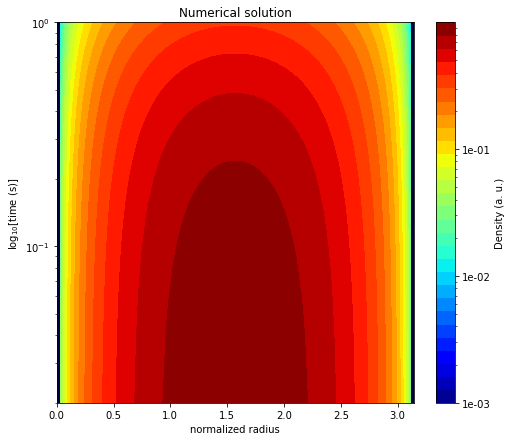

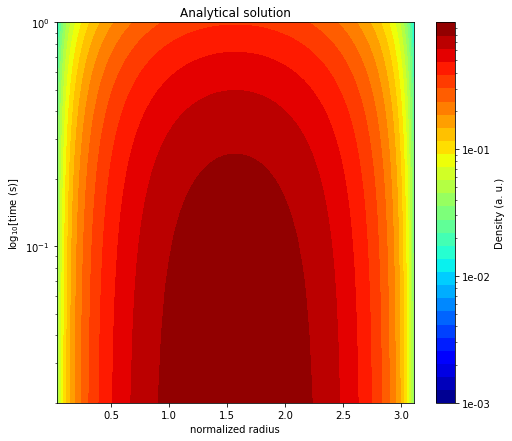

In [40]:
## sin(x) initial condition, Dirichlet boundary conditions on both edges
## 50x50 mesh

R_from = 0.  ## inner radius in meters
R_to = math.pi  ## outer radius in meters
nr = 50  ## number of mesh cells
dr = (R_to - R_from) / nr  ## distance between the centers of the mesh cells
duration = 1.  ## length of examined time evolution in seconds
nt = 50  ## number of timesteps
dt = duration / nt  ## length of one timestep

## 3D array for storing the density with the correspondant radius values
## the density values corresponding to the n-th timestep will be in the n-th line 
solution = np.zeros((nt,nr,2))
## loading the radial coordinates into the array
for j in range(nr):
    solution[:,j,0] = (j * dr) + (dr / 2) + R_from

mesh = fp.Grid1D(dx=dr, nx=nr)  ## 1D mesh based on the radial coordinates 
mesh = mesh + (R_from,)  ## translating the mesh to R_from
n = fp.CellVariable(mesh=mesh)  ## fipy.CellVariable for the density solution in each timestep

## diffusion coefficient
diffCoeff = fp.CellVariable(mesh=mesh, value=1.)
## convection coefficient - must be a vector
# cC = (numerix.sin(mesh.x)) * 2
convCoeff = fp.CellVariable(mesh=mesh, value=(0.,))

## boundary conditions
gradLeft = (0.,)  ## density gradient (at the "left side of the radius") - must be a vector
valueRight = 0.  ## density value (at the "right end of the radius")
valueLeft = 0.
#n.faceGrad.constrain(gradLeft, where=mesh.facesLeft)  ## applying Neumann boundary condition
n.constrain(valueRight, mesh.facesRight)  ## applying Dirichlet boundary condition
n.constrain(valueLeft, mesh.facesLeft)
#convCoeff.setValue(0, where=mesh.x<(R_from + dr))  ## convection coefficient 0 at the inner edge

## applying initial conditions
n.setValue(numerix.sin(mesh.x))
## the PDE
eq = (fp.TransientTerm() == fp.DiffusionTerm(coeff=diffCoeff)
      - fp.ConvectionTerm(coeff=convCoeff))

## Solving the PDE and storing the data
for i in range(nt):
    eq.solve(var=n, dt=dt)
    solution[i,0:nr,1]=copy.deepcopy(n.value)

ticks = 3
levels = 30
logdiff = 3
figsize = (8,7)
sol_min = solution[:,:,1].min()
sol_max = solution[:,:,1].max()
logmax = math.ceil(np.log10(sol_max))
logmin = logmax - logdiff
numofticks = ticks
div = logdiff // numofticks
power = np.arange((logmax - (numofticks * div)), logmax, div)
array1 = np.zeros(len(power)) + 10.
ticks1 = np.power(array1, power)
levels1 = np.logspace(logmin,logmax,levels, base=10.0)
norm = matplotlib.colors.LogNorm(vmin=(10 ** logmin),vmax=sol_max)
formatter = matplotlib.ticker.LogFormatter(10, labelOnlyBase=False)
fig = plt.figure(figsize=figsize)
plot = plt.contourf(solution[0,:,0], np.linspace(dt,duration,nt), solution[:,:,1],
                        levels=levels1, norm=norm, cmap=plt.cm.jet, datamin=0.)
axes = plt.gca()
axes.set_facecolor((0.,0.,0.25)) ## dark blue will display where the values are too small
axes.set_yscale('log')
axes.set_xlim(0.,math.pi)
cbar = plt.colorbar(ticks=ticks1, format=formatter)
cbar.set_label(r'Density (a. u.)')
plt.xlabel('normalized radius')
plt.ylabel(r'log$_{10}$[time (s)]')
plt.title(r'Numerical solution')

## new np.array for the analytical solution
analytical = np.zeros((nt,nr,2))
## loading the radial coordinates into the array
for j in range(nr):
    analytical[:,j,0] = (j * dr) + (dr / 2) + R_from

## the first line inside the for loop contains the analytical solution based on the equation above
## g()=delta_func(), K=100, t=i*dt, r=r-diracLoc 
for i in range(nt):
    analytical[i,0:nr,1] = np.sin(analytical[i,0:nr,0]) * math.exp(-i * dt)

    
## drawing the maximum-line of the analytical solution on top of the numerical
plt.plot(A_2D[:,1],A_2D[:,0], color='white')
## optional high-res figure export
#plt.savefig('conv_N.jpg',dpi=300)

## Plotting the analytical solution
sol_min = analytical[:,:,1].min()
sol_max = analytical[:,:,1].max()
logmax = math.ceil(np.log10(sol_max))
logmin = logmax - logdiff
numofticks = ticks
div = logdiff // numofticks
power = np.arange((logmax - (numofticks * div)), logmax, div)
array1 = np.zeros(len(power)) + 10.
ticks1 = np.power(array1, power)
levels1 = np.logspace(logmin,logmax,levels, base=10.0)
norm = matplotlib.colors.LogNorm(vmin=(10 ** logmin),vmax=sol_max)
formatter = matplotlib.ticker.LogFormatter(10, labelOnlyBase=False)
fig = plt.figure(figsize=figsize)
plot = plt.contourf(analytical[0,:,0], np.linspace(dt,duration,nt), analytical[:,:,1],
                        levels=levels1, norm=norm, cmap=plt.cm.jet)
axes = plt.gca()
axes.set_facecolor((0.,0.,0.25)) ## dark blue will display where the values are too small
axes.set_yscale('log')
cbar = plt.colorbar(ticks=ticks1, format=formatter)
cbar.set_label(r'Density (a. u.)')
plt.xlabel('normalized radius')
plt.ylabel(r'log$_{10}$[time (s)]')
plt.title(r'Analytical solution')
#plt.savefig('conv_A.jpg', dpi=300)

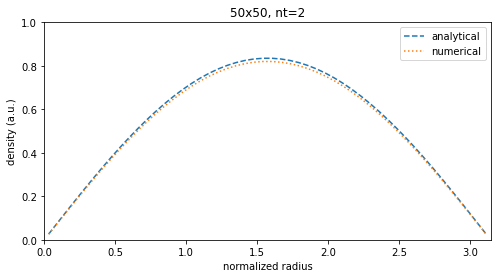

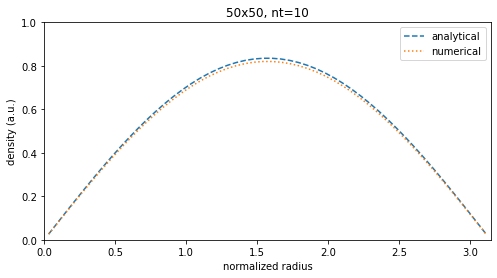

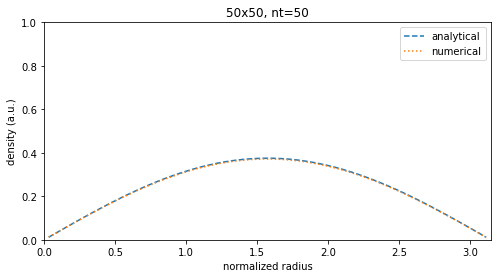

In [44]:
fig2 = plt.figure(figsize=(8,4))
plt.plot(analytical[1,0:nr,0], analytical[9,0:nr,1], label="analytical", linestyle="--")
plt.plot(solution[1,0:nr,0], solution[9,0:nr,1], label="numerical", linestyle=":")
axes = plt.gca()
axes.set_ylim(0.,1.)
axes.set_xlim(0.,math.pi)
plt.xlabel('normalized radius')
plt.ylabel('density (a.u.)')
plt.title("50x50, nt=2")
plt.legend()

fig10 = plt.figure(figsize=(8,4))
plt.plot(analytical[9,0:nr,0], analytical[9,0:nr,1], label="analytical", linestyle="--")
plt.plot(solution[9,0:nr,0], solution[9,0:nr,1], label="numerical", linestyle=":")
axes = plt.gca()
axes.set_ylim(0.,1.)
axes.set_xlim(0.,math.pi)
plt.xlabel('normalized radius')
plt.ylabel('density (a.u.)')
plt.title("50x50, nt=10")
plt.legend()

fig50 = plt.figure(figsize=(8,4))
plt.plot(analytical[49,0:nr,0], analytical[49,0:nr,1], label="analytical", linestyle="--")
plt.plot(solution[49,0:nr,0], solution[49,0:nr,1], label="numerical", linestyle=":")
axes = plt.gca()
axes.set_ylim(0.,1.)
axes.set_xlim(0.,math.pi)
plt.xlabel('normalized radius')
plt.ylabel('density (a.u.)')
plt.title("50x50, nt=50")
plt.legend()


## Diffusion in cylindrical coordinates

$$
r\frac{\partial n(r,t)}{\partial t}=D \frac{\partial}{\partial r} \Bigg(r\frac{\partial n(r,t)}{\partial r}\Bigg)
$$
The analytical solution:
$$
n(r,t)=J_0(r)e^{-Dt}
$$
where $J_0(r)$ is the Bessel function of the first kind of order 0.

C:\ProgramData\Anaconda3\lib\site-packages\fipy\variables\variable.py:1143: RuntimeWarning: invalid value encountered in true_divide
  return self._BinaryOperatorVariable(lambda a, b: a / b, other)
<ipython-input-3-a4dc56add05c>:65: UserWarning: The following kwargs were not used by contour: 'datamin'
  plot = plt.contourf(solution[0,:,0], np.linspace(dt,duration,nt), solution[:,:,1],


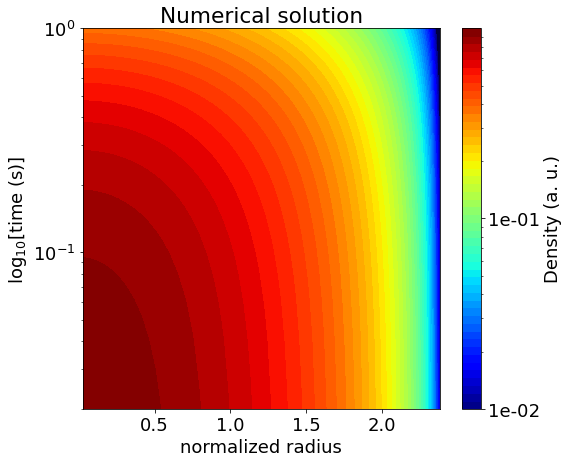

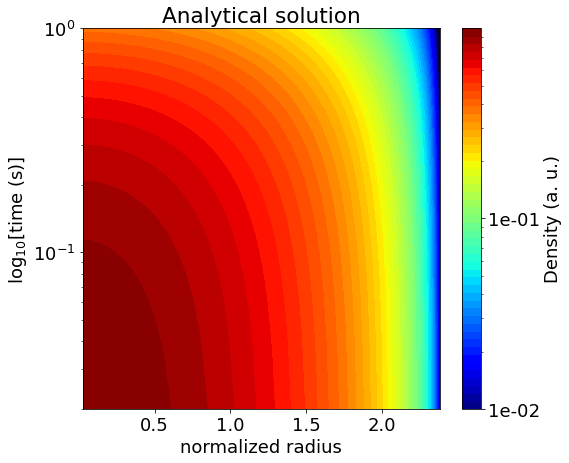

In [3]:
R_from = 0.  ## inner radius in meters
bessel_zero = sc.jn_zeros(0,1) 
R_to = bessel_zero[0]  ## outer radius in meters
nr = 50  ## number of mesh cells
dr = (R_to - R_from) / nr  ## distance between the centers of the mesh cells
duration = 1.  ## length of examined time evolution in seconds
nt = 50  ## number of timesteps
dt = duration / nt  ## length of one timestep

## 3D array for storing the density with the correspondant radius values
## the density values corresponding to the n-th timestep will be in the n-th line 
solution = np.zeros((nt,nr,2))
## loading the radial coordinates into the array
for j in range(nr):
    solution[:,j,0] = (j * dr) + (dr / 2) + R_from

mesh = fp.CylindricalGrid1D(dx=dr, nx=nr)  ## 1D mesh based on the radial coordinates 
mesh = mesh + (R_from,)  ## translating the mesh to R_from
n = fp.CellVariable(mesh=mesh)  ## fipy.CellVariable for the density solution in each timestep

## diffusion coefficient
diffCoeff = fp.CellVariable(mesh=mesh, value=1.)
D = 1.
## convection coefficient - must be a vector
# cC = (numerix.sin(mesh.x)) * 2
convCoeff = fp.CellVariable(mesh=mesh, value=(0.,))

## boundary conditions
gradLeft = (0.,)  ## density gradient (at the "left side of the radius") - must be a vector
valueRight = 0.  ## density value (at the "right end of the radius")
valueLeft = 0.
#n.faceGrad.constrain(gradLeft, where=mesh.facesLeft)  ## applying Neumann boundary condition
n.constrain(valueRight, mesh.facesRight)  ## applying Dirichlet boundary condition
n.constrain(valueLeft, mesh.facesLeft)
#convCoeff.setValue(0, where=mesh.x<(R_from + dr))  ## convection coefficient 0 at the inner edge

## applying initial conditions
n.setValue(sc.j0(mesh.x))
## the PDE
eq = (fp.TransientTerm() == fp.DiffusionTerm(coeff=diffCoeff)
      - fp.ConvectionTerm(coeff=convCoeff))

## Solving the PDE and storing the data
for i in range(nt):
    eq.solve(var=n, dt=dt)
    solution[i,0:nr,1]=copy.deepcopy(n.value)

ticks = 2
levels = 50
logdiff = 2
figsize = (8,7)
sol_min = solution[:,:,1].min()
sol_max = solution[:,:,1].max()
logmax = math.ceil(np.log10(sol_max))
logmin = logmax - logdiff
numofticks = ticks
div = logdiff // numofticks
power = np.arange((logmax - (numofticks * div)), logmax, div)
array1 = np.zeros(len(power)) + 10.
ticks1 = np.power(array1, power)
levels1 = np.logspace(logmin,logmax,levels, base=10.0)
norm = matplotlib.colors.LogNorm(vmin=(10 ** logmin),vmax=sol_max)
formatter = matplotlib.ticker.LogFormatter(10, labelOnlyBase=False)
fig = plt.figure(figsize=figsize)
plot = plt.contourf(solution[0,:,0], np.linspace(dt,duration,nt), solution[:,:,1],
                        levels=levels1, norm=norm, cmap=plt.cm.jet, datamin=0.)
axes = plt.gca()
axes.set_facecolor((0.,0.,0.25)) ## dark blue will display where the values are too small
axes.set_yscale('log')
cbar = plt.colorbar(ticks=ticks1, format=formatter)
cbar.set_label(r'Density (a. u.)')
plt.xlabel('normalized radius')
plt.ylabel(r'log$_{10}$[time (s)]')
plt.title(r'Numerical solution')
plt.savefig('verification_plots/diff_bessel_N.jpg', dpi=150)

## new np.array for the analytical solution
analytical = np.zeros((nt,nr,2))
## loading the radial coordinates into the array
for j in range(nr):
    analytical[:,j,0] = (j * dr) + (dr / 2) + R_from

## the first line inside the for loop contains the analytical solution based on the equation above
for i in range(nt):
    analytical[i,0:nr,1] = sc.j0(analytical[i,0:nr,0]) * math.exp(-D * i * dt)

## Plotting the analytical solution
sol_min = analytical[:,:,1].min()
sol_max = analytical[:,:,1].max()
logmax = math.ceil(np.log10(sol_max))
logmin = logmax - logdiff
numofticks = ticks
div = logdiff // numofticks
power = np.arange((logmax - (numofticks * div)), logmax, div)
array1 = np.zeros(len(power)) + 10.
ticks1 = np.power(array1, power)
levels1 = np.logspace(logmin,logmax,levels, base=10.0)
norm = matplotlib.colors.LogNorm(vmin=(10 ** logmin),vmax=sol_max)
formatter = matplotlib.ticker.LogFormatter(10, labelOnlyBase=False)
fig = plt.figure(figsize=figsize)
plot = plt.contourf(analytical[0,:,0], np.linspace(dt,duration,nt), analytical[:,:,1],
                        levels=levels1, norm=norm, cmap=plt.cm.jet)
axes = plt.gca()
axes.set_facecolor((0.,0.,0.25)) ## dark blue will display where the values are too small
axes.set_yscale('log')
cbar = plt.colorbar(ticks=ticks1, format=formatter)
cbar.set_label(r'Density (a. u.)')
plt.xlabel('normalized radius')
plt.ylabel(r'log$_{10}$[time (s)]')
plt.title(r'Analytical solution')
plt.savefig('verification_plots/diff_bessel_A.jpg', dpi=150)

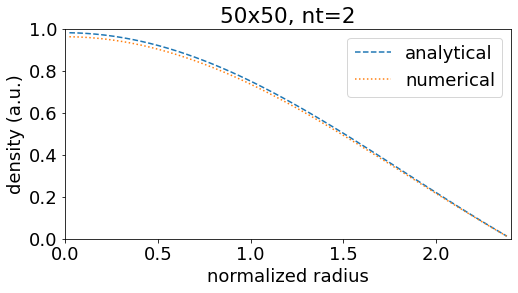

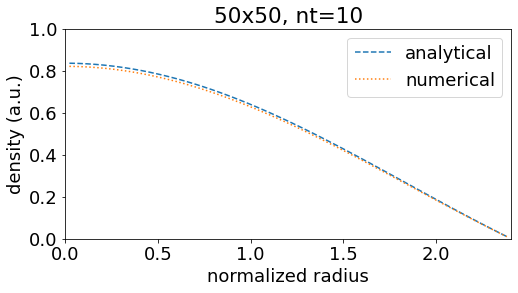

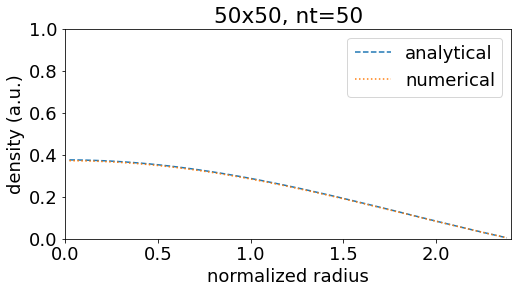

In [16]:
fig2 = plt.figure(figsize=(8,4))
plt.plot(analytical[1,0:nr,0], analytical[1,0:nr,1], label="analytical", linestyle="--")
plt.plot(solution[1,0:nr,0], solution[1,0:nr,1], label="numerical", linestyle=":")
axes = plt.gca()
axes.set_ylim(0.,1.)
axes.set_xlim(0.,bessel_zero[0])
plt.xlabel('normalized radius')
plt.ylabel('density (a.u.)')
plt.title("50x50, nt=2")
plt.legend()
plt.gcf().subplots_adjust(bottom=0.15)
plt.savefig('verification_plots/diff_bessel_step2.jpg', dpi=150)

fig10 = plt.figure(figsize=(8,4))
plt.plot(analytical[9,0:nr,0], analytical[9,0:nr,1], label="analytical", linestyle="--")
plt.plot(solution[9,0:nr,0], solution[9,0:nr,1], label="numerical", linestyle=":")
axes = plt.gca()
axes.set_ylim(0.,1.)
axes.set_xlim(0.,bessel_zero[0])
plt.xlabel('normalized radius')
plt.ylabel('density (a.u.)')
plt.title("50x50, nt=10")
plt.legend()
plt.gcf().subplots_adjust(bottom=0.15)
plt.savefig('verification_plots/diff_bessel_step10.jpg', dpi=150)

fig50 = plt.figure(figsize=(8,4))
plt.plot(analytical[49,0:nr,0], analytical[49,0:nr,1], label="analytical", linestyle="--")
plt.plot(solution[49,0:nr,0], solution[49,0:nr,1], label="numerical", linestyle=":")
axes = plt.gca()
axes.set_ylim(0.,1.)
axes.set_xlim(0.,bessel_zero[0])
plt.xlabel('normalized radius')
plt.ylabel('density (a.u.)')
plt.title("50x50, nt=50")
plt.legend()
plt.gcf().subplots_adjust(bottom=0.15)
plt.savefig('verification_plots/diff_bessel_step50.jpg', dpi=150)